#  Brain Tumor MRI Classification with Grad-CAM Visualization and Segmentation

##  Introduction
Brain tumors are abnormal growths of cells within the brain or central nervous system. Early detection and accurate classification of brain tumors play a crucial role in determining the correct treatment plan and improving patient outcomes. Magnetic Resonance Imaging (MRI) is one of the most effective non-invasive imaging techniques for detecting and analyzing brain tumors.  

# Import Libraries

In [ ]:
# --- Install Kaggle API ---
!pip install -q kaggle

# --- Setup Kaggle API Credentials ---
import os
os.makedirs('/root/.kaggle', exist_ok=True)
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# --- Download Brain Tumor MRI Dataset ---
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

# --- Unzip Dataset ---
!unzip -q brain-tumor-mri-dataset.zip -d brain-tumor-mri-dataset

print(" Dataset downloaded and extracted successfully!")

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 87% 130M/149M [00:00<00:00, 1.36GB/s]
100% 149M/149M [00:00<00:00, 1.34GB/s]
 Dataset downloaded and extracted successfully!


In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical


# Data Preprocessing

In [ ]:
train_dir = "brain-tumor-mri-dataset/Training"
test_dir = "brain-tumor-mri-dataset/Testing"


img_size = (224 , 224)
batch_size = 32


#Defining train_data again
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir ,
    image_size = img_size ,
    label_mode = "categorical" ,
    batch_size = batch_size ,)


#Defining Test_data
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = test_dir ,
    image_size = img_size ,
    label_mode = "categorical" ,
    batch_size = batch_size ,)

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


# EfficientNetB0, Model 1

### First Stage

In [ ]:
# loading pretrained base model
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False


# model architecture (Feature Extractor)
inputs = tf.keras.layers.Input(shape = (224 , 224 , 3) , name = "Input_layer")
x = base_model(inputs)
x = Conv2D(32 , 3 , padding = 'same' , activation = "relu" , name = "Top_Conv_Layer")(x)
x = tf.keras.layers.GlobalAveragePooling2D(name = "Global_avg_Pooling_2D")(x)



# ANN (Classification Part)
outputs = tf.keras.layers.Dense(4,activation = "softmax",name = "Output_layer")(x)
Model_1 = tf.keras.Model(inputs , outputs)

# model compilation and training
callback_list=[
    callbacks.EarlyStopping(monitor="val_accuracy",patience=10,restore_best_weights=True),
    callbacks.ReduceLROnPlateau(factor=0.8,monitor="val_accuracy",patience=3)
]

Model_1.compile(loss = tf.keras.losses.categorical_crossentropy ,optimizer = tf.keras.optimizers.Adam() , metrics = ['accuracy'])
Model_1_History = Model_1.fit(train_data,validation_data = test_data,epochs = 50,verbose = 1 ,callbacks = callback_list)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 76s 255ms/step - accuracy: 0.7818 - loss: 0.5550 - val_accuracy: 0.8413 - val_loss: 0.3847 - learning_rate: 0.0010
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.9202 - loss: 0.2087 - val_accuracy: 0.9191 - val_loss: 0.1885 - learning_rate: 0.0010
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - accuracy: 0.9486 - loss: 0.1318 - val_accuracy: 0.9314 - val_loss: 0.1674 - learning_rate: 0.0010
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.9641 - loss: 0.1010 - val_accuracy: 0.9397 - val_loss: 0.1637 - learning_rate: 0.0010
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - accuracy: 0.9610 - loss: 0.1012 - val_accuracy: 0.9565 - val_loss: 0.1175 - learning_rate: 0.0010


## Plot loss curves

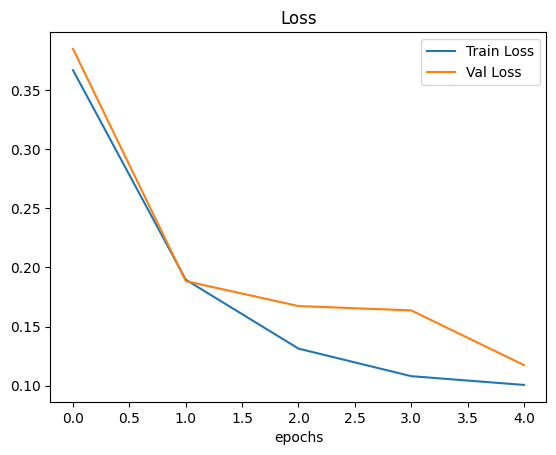

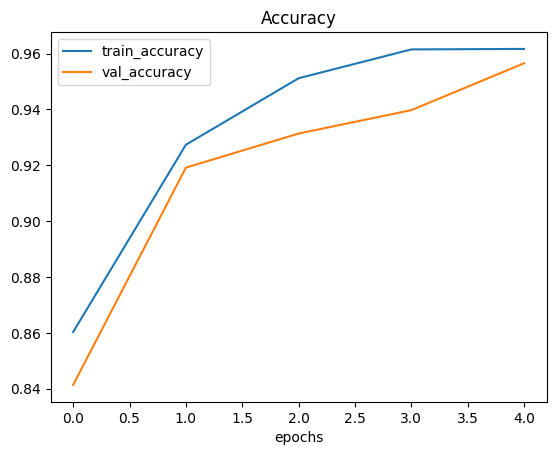

In [ ]:
def plot_loss_curves(history):
    train_loss = history.history["loss"]
    val_loss = history.history['val_loss']
    train_accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    epochs = range(len(history.history["loss"]))
    #Plot Loss
    plt.plot(epochs , train_loss , label = "Train Loss")
    plt.plot(epochs , val_loss , label = "Val Loss" )
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()
    #Plot accuracy
    plt.figure()
    plt.plot(epochs ,train_accuracy , label = "train_accuracy")
    plt.plot(epochs , val_accuracy , label = "val_accuracy" )
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()

#Use out function
plot_loss_curves(Model_1_History)

## Classificatoin Report

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import itertools

# --- Step 1: Get predictions and true labels ---
y_true = []
y_pred = []

for images, labels in test_data:
    preds = Model_1.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

class_names = test_data.class_names  # ['notumor', 'meningioma', 'glioma', 'pituitary']

# --- Step 2: Classification Report ---
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 

# Confusion Matrix

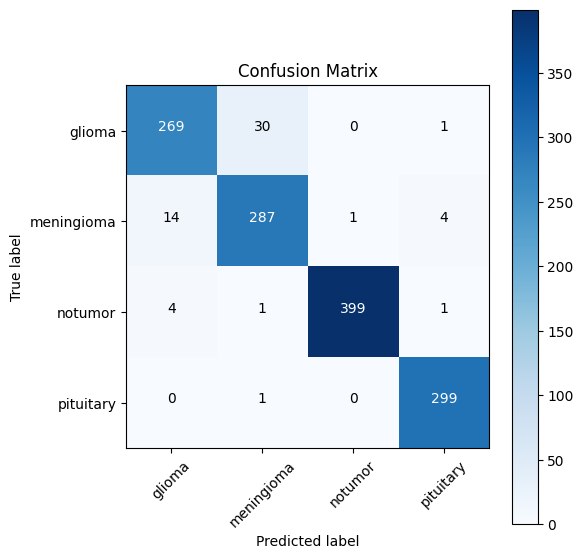

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Annotate cells
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# Inferece Prediction with Segmentation part Using Grad-cam


In [ ]:
from tensorflow import keras

# save model
Model_1.save("brain_tumor_model.h5")


# load model
Model_1 = keras.models.load_model("brain_tumor_model.h5")